In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import json
import os


In [2]:
transform={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])
}

In [3]:
train_dataset=datasets.ImageFolder(root='flowersDataset/train',transform=transform['train'])
val_dataset=datasets.ImageFolder(root='flowersDataset/test',transform=transform['test'])
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)


In [4]:
model=models.vgg16(pretrained=True)

# freeze all layers except final fully connected layer
for param in model.features.parameters():
    param.requires_grad=False

#Modify the classifier to train only the last layer
num_features=model.classifier[-1].in_features
model.classifier[-1]=nn.Linear(num_features,len(train_dataset.classes))

c:\Users\ragha\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ragha\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from torchsummary import summary
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.classifier[-1].parameters(),lr=0.001)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train_model(model,train_loader,val_loader,criterion,optimizer,epochs=2):
    train_losses,val_losses,val_accuracies=[],[],[]
    best_accuracy=0.0
    for epoch in range(epochs):
        model.train()
        running_loss=0.0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        train_losses.append(running_loss/len(train_loader))

        model.eval()
        val_loss=0.0
        correct,total=0,0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(outputs,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
        val_losses.append(val_loss/len(val_loader))
        val_accuracy=correct/total
        val_accuracies.append(val_accuracy)

        print(f'epoch {epoch+1}/{epochs}, Train loss: {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}')
        if val_accuracy>best_accuracy:
            best_accuracy=val_accuracy
            torch.save(model.state_dict(),'best_model.pth')
            print("model checkpoint saved")
        
    return train_losses,val_losses,val_accuracies


In [12]:
train_losses,val_losses,val_accuracies=train_model(model,train_loader,val_loader,criterion,optimizer)



epoch 1/2, Train loss: 0.2067, val loss 0.1655
model checkpoint saved
epoch 2/2, Train loss: 0.1994, val loss 0.1505
model checkpoint saved


[0.20674932096153498, 0.19936024975031613]


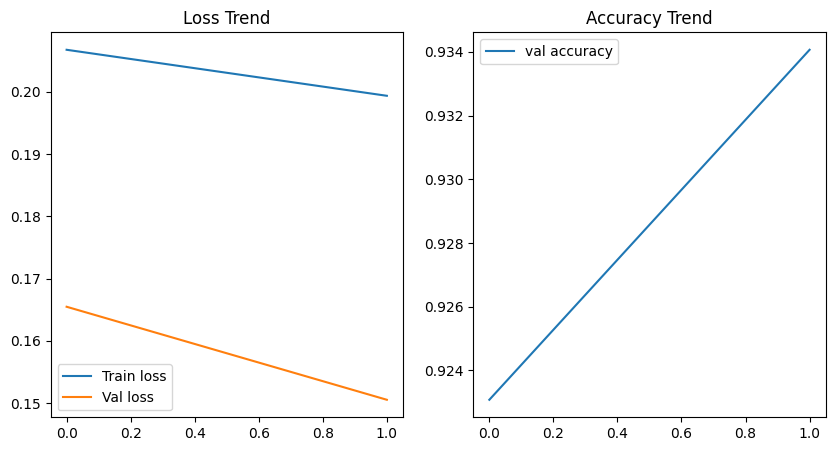

In [13]:
print(train_losses)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train loss')
plt.plot(val_losses,label='Val loss')
plt.legend()
plt.title('Loss Trend')

plt.subplot(1,2,2)
plt.plot(val_accuracies,label='val accuracy')
plt.legend()
plt.title('Accuracy Trend')
plt.show()

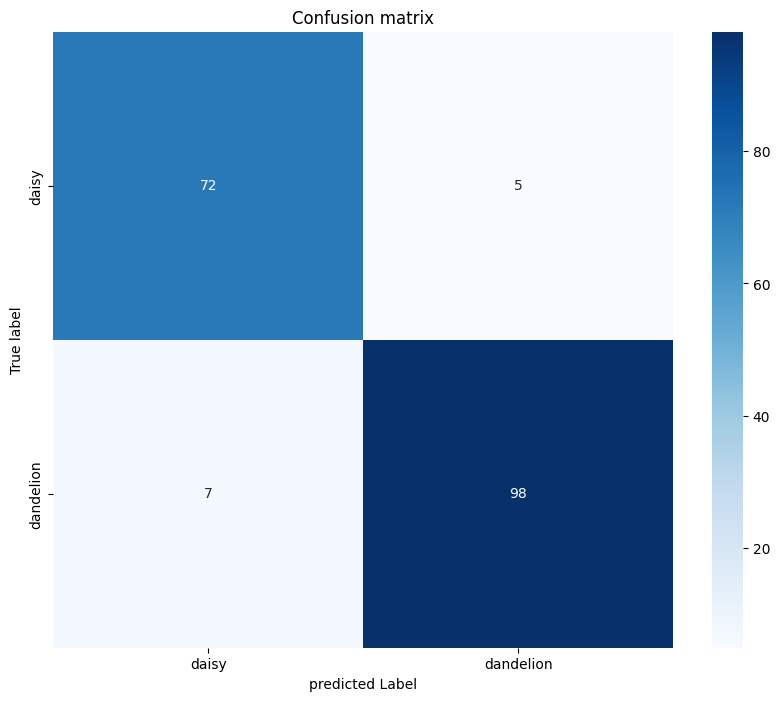

In [14]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def plot_confusion_matrix(model,dataloader):
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    all_preds,all_labels=[],[]
    with torch.no_grad():
        for images,labels in dataloader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                _,preds=torch.max(outputs,1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    cm=confusion_matrix(all_labels,all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=train_dataset.classes,yticklabels=train_dataset.classes)
    plt.xlabel('predicted Label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()

plot_confusion_matrix(model,val_loader)
                

In [ ]:
def infer(image_path):
    image=Image.open(image_path).convert('RGB')
    image=transform['test'](image).unsqueeze(0).to(device)
    with torch.no_grad():
        output=model(image)
    probs=torch.nn.functional.softmax(output[0],dim=0)
    top5_prob,top5_catid=probs.topk(5)
    results=[(train_dataset.classes[catid], prob.item()) for catid,prob in zip(top5_catid,top5_prob)]
    return results

In [ ]:
def show_image(image_path):
    image=Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()